# Alan's Stiffness Solver!

This is (hopefully) a fully general stiffness solver for a truss or spring system. To test my work, I'm going to first walk through the system using the example from the lecture notes, then use the functions I've written to solve the homework. 

Document contains:
- General stiffness solver (and the process of testing it using the truss example from our stiffness notes)
- Problems 1a, 1b, 2, and 3

First off, here's the syntax for defining points and connections:

,0,1,2,3,4,5,6,7,8,9
0,undefined,undefined,0.000000,0.000000,0.000000,-20.000000,0.000000,-20.000000,undefined,undefined
1,0.000000,0.000000,undefined,undefined,undefined,undefined,undefined,undefined,0.000000,0.000000


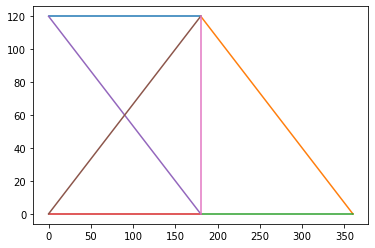

In [2]:
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import math

#points
Q = np.array([(0.0,120.0),(180.0,120.0),(360.0,0.0), (180.0,0.0), (0.0,0.0)])

#boundary conditions,
P = [["undefined","undefined"], [0.0,0.0], [0.0,-20.0], [0.0,-20.0], ["undefined","undefined"]]
delta = [[0.0,0.0],["undefined", "undefined"], ["undefined", "undefined"], ["undefined", "undefined"], [0.0,0.0]]


#joint 1, joint 2, area, E, L, n, k = EA/L
A=4
E=29000
connections = [[(0, 1), A, E, 0, 0, 0], [(1, 2), A, E, 0, 0, 0], [(2, 3), A, E, 0, 0, 0],  [(3, 4), A, E, 0, 0, 0], 
               [(0, 3), A, E, 0, 0, 0], [(1, 4), A, E, 0, 0, 0], [(1, 3), A, E, 0, 0, 0]]


def formatBounds(P, delta):
    bounds = [[],[]]
    for p in P:
        for i in p:
            bounds[0].append(i)
    for d in delta:
        for i in d:
            bounds[1].append(i)
    return bounds

def drawTable(data, title=""):
    d = pd.DataFrame(data)
    d = d.style.set_caption(title)
    display(d)


#this draws a pretty picture (assuming that Q consists of points in 2d space, no clue what matplot would do with 3d vectors)
def drawConnections(connections):
    for connection in connections:
        a = connection[0][0]
        b = connection[0][1]
        if len(Q[a]) == 2:
            plot.plot([Q[a][0], Q[b][0]],[Q[a][1], Q[b][1]])
        elif len(Q[a]) == 1:
            plot.plot([Q[a][0],Q[b][0]],[0, 0])

bounds = formatBounds(P, delta)        
drawTable(bounds, "Boundary Conditions")
drawConnections(connections)



## Calculating properties of connections

This function calculates the lengths and normal vectors for each connection. 

In [3]:
#calculate lengths and unit normal vectors
def computeNormals(connections):
    for x in range(0, len(connections)):
        c = connections[x]
        
        vector = np.subtract(Q[c[0][1]],Q[c[0][0]]) #create a vector that represents the connection
        
        #pythagorean theorem for any number of dimensions
        square_length = 0
        for i in vector:
            square_length += i**2
        length = math.sqrt(square_length)
        
        connections[x][3] = length
        
        #divide our connection vector by length to get a normal vector
        for i in range(0,len(vector)):
            vector[i] = vector[i]/length
            connections[x][4] = vector
    return connections
    
connections = computeNormals(connections)
drawTable(connections, "Connections")

,0,1,2,3,4,5
0,"(0, 1)",4,29000,180.000000,[1. 0.],0
1,"(1, 2)",4,29000,216.333077,[ 0.83205029 -0.5547002 ],0
2,"(2, 3)",4,29000,180.000000,[-1. 0.],0
3,"(3, 4)",4,29000,180.000000,[-1. 0.],0
4,"(0, 3)",4,29000,216.333077,[ 0.83205029 -0.5547002 ],0
5,"(1, 4)",4,29000,216.333077,[-0.83205029 -0.5547002 ],0
6,"(1, 3)",4,29000,120.000000,[ 0. -1.],0


## Calculating stiffness matrix


In [4]:
#calculate stiffness matrix
def calcStiffness(connections):
    # if no predefined stiffness value, calculate stiffness using EA/L. This is basically a workaround so this works for springs
    for c in connections:
        if not c[5]:
            c[5] = c[1]*c[2]/c[3]
    return connections

def calcStiffnessMatrix(connections, Q):
    #calculate the stiffness matrix using the connections, stiffnesses, nodes of truss
    connections = calcStiffness(connections)
    
    k = np.zeros((len(Q)*len(Q[0]), len(Q)*len(Q[0]))) #initialize empty matrix of correct size for k

    spring_matrix = [[1, -1], [-1, 1]] #this will be multiplied by normal vector to get matrix elements

    for c in connections:
        s = c[5] *np.outer(c[4], np.matrix.transpose(c[4])) #stiffness * n * transpose(n)
        target =  [len(Q[0])*c[0][0],len(Q[0])*c[0][1]] # where each element of the stiffness we just calculated should end up
        
        for i in target: #for location in target, add the relevant stiffness value to the k matrix
            for j in target:
                ss = s
                if i!=j:
                    ss = ss * -1

                for l in range(0,len(s)):
                    for m in range(0,len(s)):
                        k[i+l][j+m] = k[i+l][j+m] + ss[l][m] #yuck
    return k
                        
k = calcStiffnessMatrix(connections, Q)
drawTable(k, "Stiffness Matrix")

,0,1,2,3,4,5,6,7,8,9
0,1015.666883,-247.481626,-644.444444,0.000000,0.000000,0.000000,-371.222439,247.481626,0.000000,0.000000
1,-247.481626,164.987751,0.000000,0.000000,0.000000,0.000000,247.481626,-164.987751,0.000000,0.000000
2,-644.444444,0.000000,1386.889322,0.000000,-371.222439,247.481626,0.000000,0.000000,-371.222439,-247.481626
3,0.000000,0.000000,0.000000,1296.642168,247.481626,-164.987751,0.000000,-966.666667,-247.481626,-164.987751
4,0.000000,0.000000,-371.222439,247.481626,1015.666883,-247.481626,-644.444444,0.000000,0.000000,0.000000
5,0.000000,0.000000,247.481626,-164.987751,-247.481626,164.987751,0.000000,0.000000,0.000000,0.000000
6,-371.222439,247.481626,0.000000,0.000000,-644.444444,0.000000,1660.111328,-247.481626,-644.444444,0.000000
7,247.481626,-164.987751,0.000000,-966.666667,0.000000,0.000000,-247.481626,1131.654417,0.000000,0.000000
8,0.000000,0.000000,-371.222439,-247.481626,0.000000,0.000000,-644.444444,0.000000,1015.666883,247.481626
9,0.000000,0.000000,-247.481626,-164.987751,0.000000,0.000000,0.000000,0.000000,247.481626,164.987751


## Divide into submatrices

I'm pretty sure there's a more concise way to do this, but it works

In [5]:
def calcSubmatrices(bounds, k):
    #figure out which loads/displacements are defined and make an array for each so we can refer to them
    defined_ss=[]
    for i in range(0,len(bounds[1])):
        if bounds[1][i]!="undefined":
            defined_ss.append(i)
    defined_ff=[]
    for i in range(0,len(bounds[0])):
        if bounds[0][i]!="undefined":
            defined_ff.append(i)

    # initialize four empyt matrices of the right size
    k_ff=np.zeros((len(defined_ff),len(defined_ff)))
    k_fs=np.zeros((len(defined_ff), len(defined_ss)))
    k_sf=np.zeros((len(defined_ss),len(defined_ff)))
    k_ss=np.zeros((len(defined_ss),len(defined_ss)))

    #divide load and displacement vectors into fixed and supported
    P_f = []
    delta_s = []
    for f in defined_ff:
        P_f.append(bounds[0][f])
    for s in defined_ss:
        delta_s.append(bounds[1][s])

    # for each submatrix in k, assign the correct values
    
    for i in range(0,len(defined_ff)):
        for j in range(0,len(defined_ff)):
            k_ff[i][j]=k[defined_ff[i]][defined_ff[j]]

    for i in range(0,len(defined_ss)):
        for j in range(0,len(defined_ss)):
            k_ss[i][j]=k[defined_ss[i]][defined_ss[j]]

    for i in range(0,len(defined_ss)):
        for j in range(0,len(defined_ff)):
            k_sf[i][j]=k[defined_ss[i]][defined_ff[j]]

    for i in range(0,len(defined_ff)):
        for j in range(0,len(defined_ss)):
            k_fs[i][j]=k[defined_ff[i]][defined_ss[j]]

    return [k_ff, k_fs, k_sf, k_ss, defined_ff, defined_ss, P_f, delta_s]

def drawSubs(k, subs):
    # nicely print out the submatrices
    drawTable(k, "k")
    drawTable(subs[0], "k_ff")
    drawTable(subs[1], "k_fs")
    drawTable(subs[2], "k_sf")
    drawTable(subs[3], "k_ss")

subs = calcSubmatrices(bounds, k)
drawSubs(k, subs)

,0,1,2,3,4,5,6,7,8,9
0,1015.666883,-247.481626,-644.444444,0.000000,0.000000,0.000000,-371.222439,247.481626,0.000000,0.000000
1,-247.481626,164.987751,0.000000,0.000000,0.000000,0.000000,247.481626,-164.987751,0.000000,0.000000
2,-644.444444,0.000000,1386.889322,0.000000,-371.222439,247.481626,0.000000,0.000000,-371.222439,-247.481626
3,0.000000,0.000000,0.000000,1296.642168,247.481626,-164.987751,0.000000,-966.666667,-247.481626,-164.987751
4,0.000000,0.000000,-371.222439,247.481626,1015.666883,-247.481626,-644.444444,0.000000,0.000000,0.000000
5,0.000000,0.000000,247.481626,-164.987751,-247.481626,164.987751,0.000000,0.000000,0.000000,0.000000
6,-371.222439,247.481626,0.000000,0.000000,-644.444444,0.000000,1660.111328,-247.481626,-644.444444,0.000000
7,247.481626,-164.987751,0.000000,-966.666667,0.000000,0.000000,-247.481626,1131.654417,0.000000,0.000000
8,0.000000,0.000000,-371.222439,-247.481626,0.000000,0.000000,-644.444444,0.000000,1015.666883,247.481626
9,0.000000,0.000000,-247.481626,-164.987751,0.000000,0.000000,0.000000,0.000000,247.481626,164.987751


,0,1,2,3,4,5
0,1386.889322,0.000000,-371.222439,247.481626,0.000000,0.000000
1,0.000000,1296.642168,247.481626,-164.987751,0.000000,-966.666667
2,-371.222439,247.481626,1015.666883,-247.481626,-644.444444,0.000000
3,247.481626,-164.987751,-247.481626,164.987751,0.000000,0.000000
4,0.000000,0.000000,-644.444444,0.000000,1660.111328,-247.481626
5,0.000000,-966.666667,0.000000,0.000000,-247.481626,1131.654417


,0,1,2,3
0,-644.444444,0.000000,-371.222439,-247.481626
1,0.000000,0.000000,-247.481626,-164.987751
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,-371.222439,247.481626,-644.444444,0.000000
5,247.481626,-164.987751,0.000000,0.000000


,0,1,2,3,4,5
0,-644.444444,0.000000,0.000000,0.000000,-371.222439,247.481626
1,0.000000,0.000000,0.000000,0.000000,247.481626,-164.987751
2,-371.222439,-247.481626,0.000000,0.000000,-644.444444,0.000000
3,-247.481626,-164.987751,0.000000,0.000000,0.000000,0.000000


,0,1,2,3
0,1015.666883,-247.481626,0.000000,0.000000
1,-247.481626,164.987751,0.000000,0.000000
2,0.000000,0.000000,1015.666883,247.481626
3,0.000000,0.000000,247.481626,164.987751


## All the complex matrix algebra bits


In [6]:
def calcDeltaR(subs, bounds):
    # take our big submatrix vector from earlier and separate it back out into components
    k_ff = subs[0]
    k_fs = subs[1]
    k_sf = subs[2]
    k_ss = subs[3]
    defined_ff = subs[4]
    defined_ss = subs[5]
    P_f = subs[6]
    delta_s = subs[7]
    
    
    A = np.asmatrix(k_ff)
    
    
    # inverse(k_ff) * (P_f - k_fs delta_s)
    delta_f = np.array(np.matmul(np.linalg.inv(A), P_f - np.matmul(k_fs, delta_s)))
    
    #shove that result into the bounds array so it can be reported
    for i in range(0, len(delta_f[0])):
        bounds[1][defined_ff[i]] = delta_f[0][i]
    
    # k_sf delta_f + k_ss delta_s
    R_s = np.array(np.transpose(np.add(np.matmul(k_sf, np.transpose(delta_f)), 
                              np.matmul(k_ss, np.matrix.transpose(np.asmatrix(delta_s))))))
    
    #report results
    for i in range(0, len(R_s[0])):
        bounds[0][defined_ss[i]] = R_s[0][i]

    return(bounds)


bounds = calcDeltaR(subs, bounds)
drawTable(bounds, "Bounds")

,0,1,2,3,4,5,6,7,8,9
0,-90.000000,20.000000,0.000000,0.000000,0.000000,-20.000000,0.000000,-20.000000,90.000000,20.000000
1,0.000000,0.000000,0.093103,-0.260876,-0.139655,-0.731235,-0.093103,-0.260876,0.000000,0.000000


## Calculate internal forces given displacements and the number of dimensions the problem exists in

In [7]:
def calcInternalForces(connections, bounds, dimensions):
    f = [] # initialize a list of forces

    # for each connection, find the difference between its beginning and end points. 
    # Then dot that with the normal vector for that connection
    for c in connections:
        d = bounds[1]
        x_1 = d[c[0][0]*dimensions:c[0][0]*dimensions + dimensions]
        x_2 = d[c[0][1]*dimensions:c[0][1]*dimensions + dimensions]
        x_i = np.subtract(x_2, x_1)
        dot = np.dot(x_i, c[4])

        f.append([c[0], round(dot*c[5], 4)])
        
    return(f)
                 
f = calcInternalForces(connections, bounds, len(Q[0]))
drawTable(f, "internal forces")

,0,1
0,"(0, 1)",60.000000
1,"(1, 2)",36.055500
2,"(2, 3)",-30.000000
3,"(3, 4)",-60.000000
4,"(0, 3)",36.055500
5,"(1, 4)",-36.055500
6,"(1, 3)",-0.000000


## Define a function to do all of that for me at once

Now that I have functions for each step of the process, I can just call them in order to analyze another truss. This function calculates the external reactions, displacements, and internal forces for any truss in any number of dimensions (at least hypothetically--I haven't tested for more than 2)

In [8]:
def main(Q, P, delta, connections, print_connections = False, print_subs = False):
    #make bounds easier to read for the computer, draw truss
    bounds = formatBounds(P, delta)        
    drawTable(bounds, "Boundary Conditions")
    drawConnections(connections)

    #compute normals for connections
    connections = computeNormals(connections)

    #calculate stiffness matrix
    k = calcStiffnessMatrix(connections, Q)                    
    drawTable(k, "Stiffness Matrix")
    if print_connections:
        drawTable(connections, "Connections")

    #calculate submatrices
    subs = calcSubmatrices(bounds, k)
    if print_subs:
        drawSubs(k, subs)
        
    #drawTable(bounds, "Bounds")

    #calculate displacements
    displacements_reactions = calcDeltaR(subs, bounds)
    drawTable(displacements_reactions, "External Forces and Displacements")

    #calculate internal forces
    f = calcInternalForces(connections, displacements_reactions, len(Q[0]))
    drawTable(f, "Internal Forces")

# Problem 1a

,0,1,2,3
0,undefined,0.500000,0.500000,undefined
1,0.000000,undefined,undefined,0.000000


,0,1,2,3
0,0.100000,-0.100000,0.000000,0.000000
1,-0.100000,0.300000,-0.200000,0.000000
2,0.000000,-0.200000,0.500000,-0.300000
3,0.000000,0.000000,-0.300000,0.300000


,0,1,2,3
0,-0.318182,0.500000,0.500000,-0.681818
1,0.000000,3.181818,2.272727,0.000000


,0,1
0,"(0, 1)",0.318200
1,"(1, 2)",-0.181800
2,"(2, 3)",-0.681800


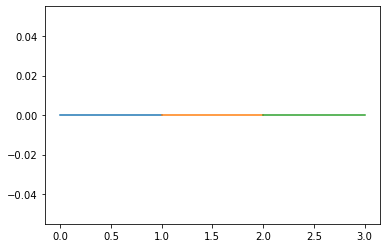

In [9]:
#define nodes
Q = np.array([[0.0],[1.0],[2.0],[3.0]])

#define forces and displacements
P = [["undefined"], [0.5], [0.5], ["undefined"]]
delta = [[0.0],["undefined"],["undefined"],[0.0]]

#define connection properties
A=1
E=1

connections = [[(0, 1), A, E, 0, 0, .1], [(1, 2), A, E, 0, 0, .2], [(2, 3), A, E, 0, 0, .3]]

#make the magic happen
main(Q, P, delta, connections)

# Problem 1b

,0,1,2,3
0,undefined,0.500000,0.000000,0.500000
1,0.000000,undefined,undefined,undefined


,0,1,2,3
0,0.100000,-0.100000,0.000000,0.000000
1,-0.100000,0.300000,-0.200000,0.000000
2,0.000000,-0.200000,0.500000,-0.300000
3,0.000000,0.000000,-0.300000,0.300000


,0,1,2,3
0,-1.000000,0.500000,0.000000,0.500000
1,0.000000,10.000000,12.500000,14.166667


,0,1
0,"(0, 1)",1.000000
1,"(1, 2)",0.500000
2,"(2, 3)",0.500000


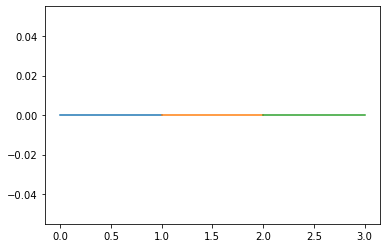

In [10]:
#nodes
Q = np.array([[0.0],[1.0],[2.0],[3.0]])

#forces/displacements
P = [["undefined"], [0.5], [0.0], [0.5]]
delta = [[0.0],["undefined"],["undefined"],["undefined"]]

#connections
A=1
E=1

connections = [[(0, 1), A, E, 0, 0, .1], [(1, 2), A, E, 0, 0, .2], [(2, 3), A, E, 0, 0, .3]]

#magic
main(Q, P, delta, connections)

# Problem 2

,0,1,2,3,4,5,6,7,8,9
0,undefined,undefined,0.000000,-3.000000,0.000000,-3.000000,undefined,undefined,0.000000,-5.000000
1,0.000000,0.000000,undefined,undefined,undefined,undefined,0.000000,0.000000,undefined,undefined


,0,1,2,3,4,5,6,7,8,9
0,1073.333333,320.000000,-240.000000,-320.000000,0.000000,0.000000,0.000000,0.000000,-833.333333,0.000000
1,320.000000,426.666667,-320.000000,-426.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-240.000000,-320.000000,1313.333333,0.000000,-833.333333,0.000000,0.000000,0.000000,-240.000000,320.000000
3,-320.000000,-426.666667,0.000000,853.333333,0.000000,0.000000,0.000000,0.000000,320.000000,-426.666667
4,0.000000,0.000000,-833.333333,0.000000,1313.333333,0.000000,-240.000000,320.000000,-240.000000,-320.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,853.333333,320.000000,-426.666667,-320.000000,-426.666667
6,0.000000,0.000000,0.000000,0.000000,-240.000000,320.000000,1073.333333,-320.000000,-833.333333,0.000000
7,0.000000,0.000000,0.000000,0.000000,320.000000,-426.666667,-320.000000,426.666667,0.000000,0.000000
8,-833.333333,0.000000,-240.000000,320.000000,-240.000000,-320.000000,-833.333333,0.000000,2146.666667,0.000000
9,0.000000,0.000000,320.000000,-426.666667,-320.000000,-426.666667,0.000000,0.000000,0.000000,853.333333


,0,1,2,3,4,5
0,"(0, 4)",6,10000,72.000000,[1. 0.],833.333333
1,"(3, 4)",6,10000,72.000000,[-1. 0.],833.333333
2,"(0, 1)",4,10000,60.000000,[0.6 0.8],666.666667
3,"(1, 4)",4,10000,60.000000,[ 0.6 -0.8],666.666667
4,"(2, 4)",4,10000,60.000000,[-0.6 -0.8],666.666667
5,"(2, 3)",4,10000,60.000000,[ 0.6 -0.8],666.666667
6,"(1, 2)",6,10000,72.000000,[1. 0.],833.333333


,0,1,2,3,4,5,6,7,8,9
0,1073.333333,320.000000,-240.000000,-320.000000,0.000000,0.000000,0.000000,0.000000,-833.333333,0.000000
1,320.000000,426.666667,-320.000000,-426.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-240.000000,-320.000000,1313.333333,0.000000,-833.333333,0.000000,0.000000,0.000000,-240.000000,320.000000
3,-320.000000,-426.666667,0.000000,853.333333,0.000000,0.000000,0.000000,0.000000,320.000000,-426.666667
4,0.000000,0.000000,-833.333333,0.000000,1313.333333,0.000000,-240.000000,320.000000,-240.000000,-320.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,853.333333,320.000000,-426.666667,-320.000000,-426.666667
6,0.000000,0.000000,0.000000,0.000000,-240.000000,320.000000,1073.333333,-320.000000,-833.333333,0.000000
7,0.000000,0.000000,0.000000,0.000000,320.000000,-426.666667,-320.000000,426.666667,0.000000,0.000000
8,-833.333333,0.000000,-240.000000,320.000000,-240.000000,-320.000000,-833.333333,0.000000,2146.666667,0.000000
9,0.000000,0.000000,320.000000,-426.666667,-320.000000,-426.666667,0.000000,0.000000,0.000000,853.333333


,0,1,2,3,4,5
0,1313.333333,0.000000,-833.333333,0.000000,-240.000000,320.000000
1,0.000000,853.333333,0.000000,0.000000,320.000000,-426.666667
2,-833.333333,0.000000,1313.333333,0.000000,-240.000000,-320.000000
3,0.000000,0.000000,0.000000,853.333333,-320.000000,-426.666667
4,-240.000000,320.000000,-240.000000,-320.000000,2146.666667,0.000000
5,320.000000,-426.666667,-320.000000,-426.666667,0.000000,853.333333


,0,1,2,3
0,-240.000000,-320.000000,0.000000,0.000000
1,-320.000000,-426.666667,0.000000,0.000000
2,0.000000,0.000000,-240.000000,320.000000
3,0.000000,0.000000,320.000000,-426.666667
4,-833.333333,0.000000,-833.333333,0.000000
5,0.000000,0.000000,0.000000,0.000000


,0,1,2,3,4,5
0,-240.000000,-320.000000,0.000000,0.000000,-833.333333,0.000000
1,-320.000000,-426.666667,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,-240.000000,320.000000,-833.333333,0.000000
3,0.000000,0.000000,320.000000,-426.666667,0.000000,0.000000


,0,1,2,3
0,1073.333333,320.000000,0.000000,0.000000
1,320.000000,426.666667,0.000000,0.000000
2,0.000000,0.000000,1073.333333,-320.000000
3,0.000000,0.000000,-320.000000,426.666667


,0,1,2,3,4,5,6,7,8,9
0,4.125000,5.500000,0.000000,-3.000000,0.000000,-3.000000,-4.125000,5.500000,0.000000,-5.000000
1,0.000000,0.000000,0.003600,-0.015591,-0.003600,-0.015591,0.000000,0.000000,0.000000,-0.024150


,0,1
0,"(0, 4)",0.000000
1,"(3, 4)",-0.000000
2,"(0, 1)",-6.875000
3,"(1, 4)",3.125000
4,"(2, 4)",3.125000
5,"(2, 3)",-6.875000
6,"(1, 2)",-6.000000


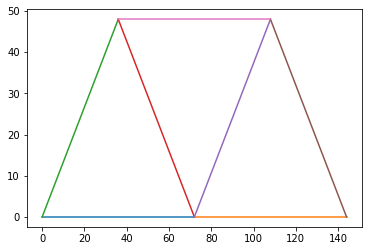

In [19]:
#nodes
Q = np.array([[0.0, 0.0],[3.0*12, 4.0*12],[9.0*12, 4.0*12],[12.0*12, 0.0], [6.0*12, 0.0]])

#forces/displacements
P = [["undefined", "undefined"], [0.0, -3.0], [0.0, -3.0], ["undefined", "undefined"], [0.0, -5.0]]
delta = [[0.0, 0.0],["undefined", "undefined"],["undefined", "undefined"],[0.0, 0.0], ["undefined", "undefined"]]

#connections
A=1
E=10000

connections = [[(0, 4), 6, E, 0, 0, 0], #a
               [(3, 4), 6, E, 0, 0, 0], #b
               [(0, 1), 4, E, 0, 0, 0], #c
               [(1, 4), 4, E, 0, 0, 0], #d
               [(2, 4), 4, E, 0, 0, 0], #e
               [(2, 3), 4, E, 0, 0, 0], #f
               [(1, 2), 6, E, 0, 0, 0]  #g
              ]
#magic
main(Q, P, delta, connections, True, True)

# Problem 3

,0,1,2
0,undefined,240.000000,160.000000
1,0.000000,undefined,undefined


,0,1,2
0,33166.666667,-4166.666667,-29000.000000
1,-4166.666667,22291.666667,-18125.000000
2,-29000.000000,-18125.000000,47125.000000


,0,1,2
0,-400.000000,240.000000,160.000000
1,0.000000,0.019682,0.010965


,0,1
0,"(0, 2)",158.995800
1,"(0, 1)",82.008400
2,"(1, 2)",-157.991600
3,"(0, 2)",158.995800


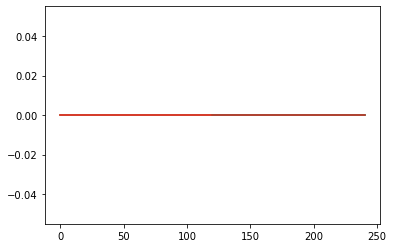

In [12]:
#nodes
Q = np.array([[0.0],[120.0],[240.0]])

#forces/displacements
P = [["undefined"], [240.0], [160.0]]
delta = [[0.0],["undefined"],["undefined"]]

#connections
E=29000

connections = [[(0, 2), 120, E, 0, 0, 0], #a
               [(0, 1), 50, 10000, 0, 0, 0], #b
               [(1, 2), 75, E, 0, 0, 0], #c
               [(0, 2), 120, E, 0, 0, 0] #d
              ]
#magic
main(Q, P, delta, connections)

## Area of *a* and *d* reduced by half

This program is good for exactly one thing and that's quickly calculating new stiffness systems. Since this takes me 30 seconds, there's no reason *not* to recalculate.

,0,1,2
0,undefined,240.000000,160.000000
1,0.000000,undefined,undefined


,0,1,2
0,18666.666667,-4166.666667,-14500.000000
1,-4166.666667,22291.666667,-18125.000000
2,-14500.000000,-18125.000000,32625.000000


,0,1,2
0,-400.000000,240.000000,160.000000
1,0.000000,0.026909,0.019854


,0,1
0,"(0, 2)",143.939400
1,"(0, 1)",112.121200
2,"(1, 2)",-127.878800
3,"(0, 2)",143.939400


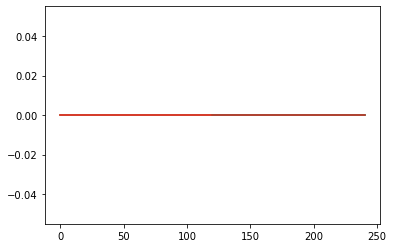

In [13]:
#nodes
Q = np.array([[0.0],[120.0],[240.0]])

#forces/displacements
P = [["undefined"], [240.0], [160.0]]
delta = [[0.0],["undefined"],["undefined"]]

#connections
E=29000

connections = [[(0, 2), 120/2, E, 0, 0, 0], #a
               [(0, 1), 50, 10000, 0, 0, 0], #b
               [(1, 2), 75, E, 0, 0, 0], #c
               [(0, 2), 120/2, E, 0, 0, 0] #d
              ]
#magic
main(Q, P, delta, connections)